In [1]:
import gc
import numpy
import pandas
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
train_data = pandas.read_csv('train_data_denoise.csv')
train_data.drop(['Unnamed: 0'], axis=1, inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64381 entries, 0 to 64380
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   PT N2 'C' Speed                        64381 non-null  float64
 1   Gear High Speed Drive End X Vibr       64381 non-null  float64
 2   Gear High Speed Drive End Y Vibr       64381 non-null  float64
 3   Gear High Speed Non-Drive End X Vibr   64381 non-null  float64
 4   Gear High Speed Non-Drive End Y Vibr   64381 non-null  float64
 5   Gear LS Shaft Axial Displ 1            64381 non-null  float64
 6   Gear LS Shaft Axial Displ 2            64381 non-null  float64
 7   Gear Low Speed Drive End X Vibr        64381 non-null  float64
 8   Gear Low Speed DriveEnd Y Vibr         64381 non-null  float64
 9   Gear Low Speed Non-Drive End X Vibr    64381 non-null  float64
 10  Gear Low Speed Non-Drive End Y Vibr    64381 non-null  float64
 11  PT

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

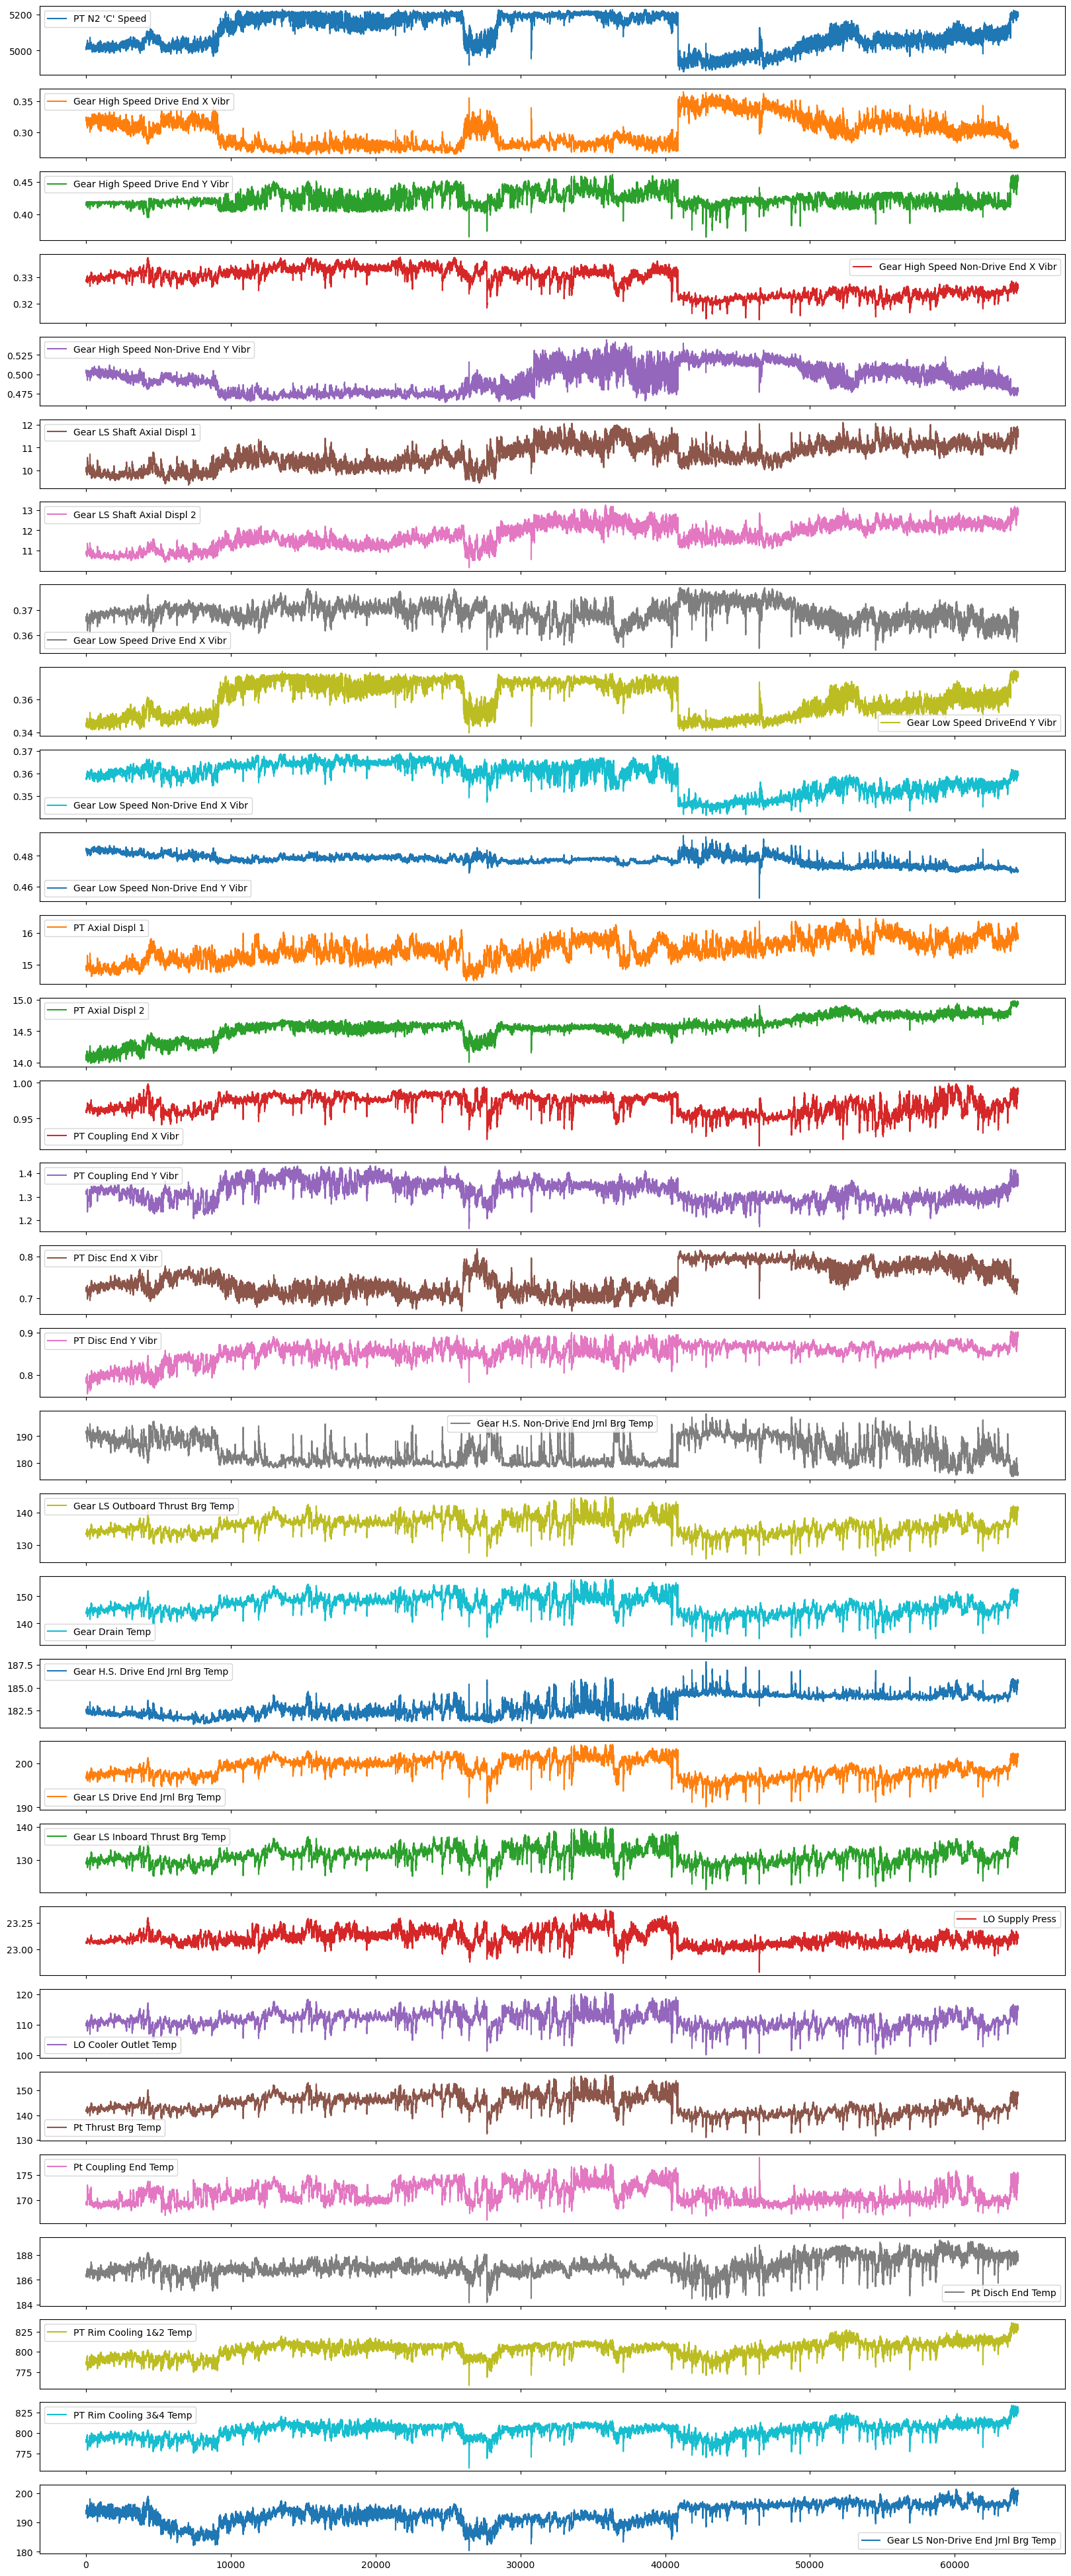

In [3]:
train_data.plot(subplots=True, figsize=(20, 50))

In [4]:
features = train_data.columns.to_list()

# standard scaling
# from sklearn.preprocessing import StandardScaler
# # create scaler for each feature
# scalers = {}
# for feature in features:
#     scaler = StandardScaler()
#     scaler.fit(train_data[feature].values.reshape(-1, 1))
#     scalers[feature] = scaler

# # transform data
# train_data_scaled = pandas.DataFrame()
# for feature in features:
#     scaler = scalers[feature]
#     train_data_scaled[feature] = scaler.transform(train_data[feature].values.reshape(-1, 1)).flatten()

# train_data_scaled.plot(subplots=True, figsize=(20, 50))

print("train data: ",train_data.shape)

train data:  (64381, 31)


In [5]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [6]:
x_train, y_train = lstm_data_transform(train_data.values, train_data.values, num_steps=10)

In [7]:
x_train.shape, y_train.shape

((64371, 10, 31), (64371, 31))

In [9]:
# LSTM using tensorflow

def lstm_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(50, input_shape=(10, len(features)-1), return_sequences=True))
    model.add(tf.keras.layers.LSTM(50))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')

    return model

lstm_model().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 50)            16200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 36,451
Trainable params: 36,451
Non-trainable params: 0
_________________________________________________________________


In [10]:
y_train[:,1].shape

(64371,)

In [11]:
# create early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# create model for each feature, and train it
models = {}

# train with GPU
with tf.device('/GPU:0'):
    for i, feature in enumerate(features):
        print('Training model for feature', feature)
        model = lstm_model()
        history = model.fit(
            # remove features that are not the one we are training
            x_train[:, :, [j for j in range(len(features)) if j != i]],
            y_train[:, i],
            epochs=50,
            batch_size=64,
            validation_split=0.2,
            callbacks=[callback],
            verbose=1
        )
        models[feature] = model
        model.save('models_lstm/' + feature + '.h5')
        del model

Training model for feature PT N2 'C' Speed
Epoch 1/50
805/805 [==============================] - 10s 8ms/step - loss: 25772060.0000 - val_loss: 25245234.0000
Epoch 2/50
805/805 [==============================] - 6s 7ms/step - loss: 25345040.0000 - val_loss: 24832570.0000
Epoch 3/50
805/805 [==============================] - 6s 7ms/step - loss: 24933556.0000 - val_loss: 24426594.0000
Epoch 4/50
805/805 [==============================] - 6s 7ms/step - loss: 24527532.0000 - val_loss: 24025276.0000
Epoch 5/50
805/805 [==============================] - 7s 8ms/step - loss: 24125828.0000 - val_loss: 23627896.0000
Epoch 6/50
805/805 [==============================] - 7s 9ms/step - loss: 23727872.0000 - val_loss: 23234194.0000
Epoch 7/50
805/805 [==============================] - 7s 9ms/step - loss: 23333498.0000 - val_loss: 22843984.0000
Epoch 8/50
805/805 [==============================] - 7s 9ms/step - loss: 22942566.0000 - val_loss: 22457176.0000
Epoch 9/50
805/805 [========================